# <center> </center>
# <center> 5. NNAR Application
## <center> ECO374

If using Colab, mount Google Drive and set path to files

In [1]:
import os
IN_COLAB = 'COLAB_GPU' in os.environ  
if IN_COLAB:
  from google.colab import drive; mount_path = '/content/drive'
  not os.path.ismount(mount_path) and drive.mount(mount_path)
  os.chdir('/content/drive/MyDrive/Colab Notebooks/Python_code') # Set Python file directory

Set up R for Python

In [2]:
import R_for_Python_setup as RPY
RPY.setup_R()
ro, pandas2ri, StrVector = RPY.initialize_rpy2()
%load_ext rpy2.ipython

R installed
Operating system: Windows
Development tool: Anaconda


Load R packages

In [3]:
R_packages = ['forecast']
RPY.load_R_packages(R_packages)

R packages loaded: forecast


Load Python libraries

In [4]:
pth_packages = ['yfinance', 'pandas_datareader']
import subprocess, sys
for pkg in pth_packages: subprocess.run([sys.executable, '-m', 'pip', 'install', pkg, '--quiet'], check=True)
import numpy as np, pandas as pd, pandas_datareader.data as web, datetime as dt 
import matplotlib.pyplot as plt, matplotlib.dates as mdates, yfinance as yf 
from pandas.tseries.offsets import BDay; from pandas.tseries.holiday import USFederalHolidayCalendar
busdays = pd.offsets.CustomBusinessDay(calendar = USFederalHolidayCalendar())

# 1. Data
iShares Core S&P Total U.S. Stock Market ETF ([Source](https://finance.yahoo.com/quote/ITOT/))

In [5]:
ITOT_table = yf.download('ITOT', start='2022-11-01', end='2023-09-06', progress=False, auto_adjust=False)
ITOT = ITOT_table['Close']
seed = 2345

Plot the data

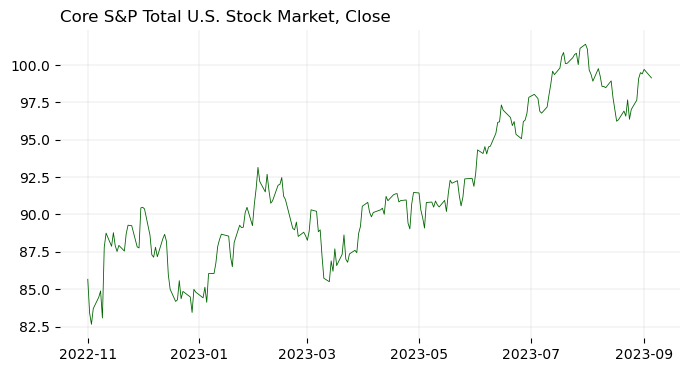

In [6]:
plt.figure(figsize=(8, 4))
plt.plot(ITOT, '-', color='darkgreen', linewidth=0.6)
plt.title('Core S&P Total U.S. Stock Market, Close', loc='left')
plt.grid(which='major', color='lightgrey', linewidth=0.3)
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=2))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
plt.box(False)
plt.show()

# 2. Neural Network (FFN) Autoregression

The `nnetar()` function from R package *forecast* specifies a feed-forward neural network with lagged values of y as inputs and 1 hidden layer. The function fits an NNAR(p,P,size)m model.

- p is the number of non-seasonal lags used as inputs.    
- P is the number of seasonal lags used as inputs.     
- size is the number of nodes in the hidden layer (there is only one hidden layer by default).    
- m = frequency(y) is the automatically determined seasonal frequency of the data.    

If the values of p and P are not specified, nnetar() runs the default model.     
For p the default is the optimal number of lags (according to the AIC) for a linear AR(p) model.     
For size the default is size=(p+P+1)/2 (rounded to the nearest integer).    

For a simple illustration of how to implement the NNAR model, we will first fit the model to the data with arbitrarily selected 1 autoregressive lag and 2 hidden neurons in one hidden layer. We will then optimize the number of lags and neurons with time series cross-validation in the next section.

In [7]:
ro.globalenv['ITOT'] = ITOT['ITOT'] # copy data from Python to R
ro.globalenv['seed'] = seed

In [8]:
%%R
base::set.seed(seed)
nnetar_model <- forecast::nnetar(y=ITOT, p=1, P=0, size=2) # model fit
y_hat <- forecast::forecast(nnetar_model, h=1) # forecast 1 step ahead

# 3. Time Series Cross-validation for NNAR
Define a function for time-series cross-validation for `nnetar()`    
Arguments: full data set and parameters (p, P, size)    
The data set will be split into training and validation set based on evaluation on a rolling forecasting origin   

In [9]:
%%R
TSCV_nnetar <- function(data, p, P, size) {
  TT <- length(data)
  T1 <- floor(TT/5) # start at 20% of the sample size
  step <- 20 # forecast horizon for MSE
  MSE_t <- matrix(0,nrow=TT-T1+1,ncol=1) # initialize
  y_hat <- MSE_t # initialize
  tseq <- seq(from=T1, to=TT, by=step)
  tseq <- tseq[-length(tseq)]
  for (j in tseq) {
    #print(j) # display progress through data
    base::set.seed(seed)
    nnetar_model <- forecast::nnetar(y=data[1:j-1], p=p, P=P, size=size) # fit nnetar model on the training set
    NN_f <- forecast::forecast(nnetar_model,h=step) # generate forecast
    y_hat <- as.numeric(NN_f$mean)
    js <- j+step-1
    MSE_t[(j-T1+1):(js-T1+1)] <- (as.numeric(data[j:js])-y_hat)^2
  }
  MSE_validation <- mean(MSE_t[1:(js-T1+1)])
  return(MSE_validation)
}

Obtain time series validation MSE for a sequence of lags and `size=` parameters (number of hidden neurons)

In [10]:
%%R
size_max <- 8
lag_max <- 10
TSCV <- matrix(0, nrow=size_max, ncol=lag_max)

for (s in 1:size_max) {
  for (k in 1:lag_max) {
    TSCV[s,k] <- TSCV_nnetar(data=ITOT, p=k, P=0, size=s)
    #writeLines(paste("Size = ", s, "Lag = ", k, "  Validation MSE = ", TSCV[k,s]))
  }}

In [11]:
TSCV = ro.globalenv['TSCV']
size_max = int(ro.globalenv['size_max'][0])
TSCV = pd.DataFrame(TSCV)

Plot validation MSE

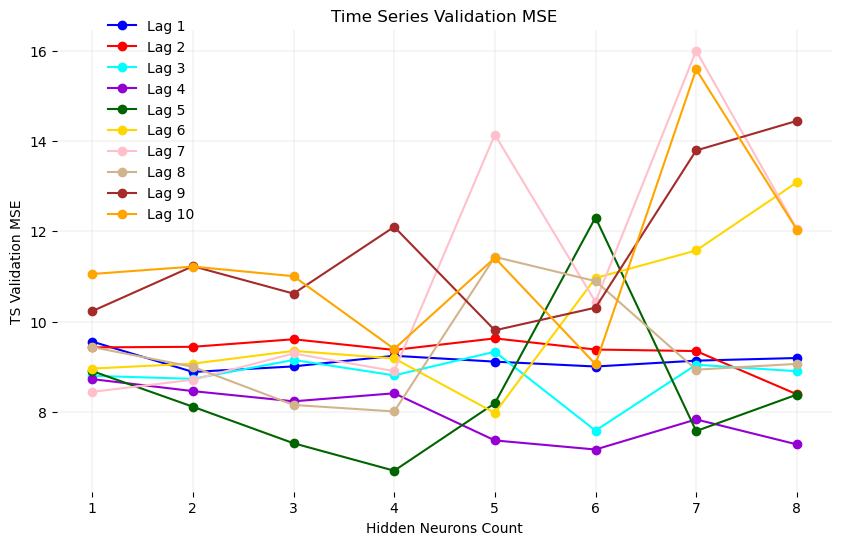

In [12]:
colors = {"lag_1": "blue", "lag_2": "red", "lag_3": "cyan", "lag_4": "darkviolet",
          "lag_5": "darkgreen", "lag_6": "gold", "lag_7": "pink", "lag_8": "tan",
          "lag_9": "brown", "lag_10": "orange"}

plt.figure(figsize=(10, 6))
for lag in range(TSCV.shape[1]):  
    plt.plot(TSCV.index+1, TSCV.iloc[:, lag], marker='o', label=f'Lag {lag+1}', color=colors[f'lag_{lag+1}'])

plt.xlabel('Hidden Neurons Count')
plt.ylabel('TS Validation MSE')
plt.title('Time Series Validation MSE')
plt.legend(loc='upper left', bbox_to_anchor=(0.05,1.05), frameon=False)
plt.grid(which='major', color='lightgrey', linewidth=0.3)
plt.box(False)
plt.show()

# 4. Forecast
Forecast with the cross-validated NNAR

In [13]:
%%R 
h_steps <- 10 # set the forecast time horizon
base::set.seed(seed)
nnetar_model <- nnetar(y=ITOT, p=5, P=0, size=4) # train the model on all data
ITOT_f <- forecast::forecast(nnetar_model, h=h_steps) # generate forecast
ITOT_f <- ITOT_f$mean

In [14]:
ITOT_fc = ro.globalenv['ITOT_f']
h_steps = int(ro.globalenv['h_steps'][0])

In [15]:
last_date = ITOT.index[-1]
id_f = pd.date_range(last_date + busdays, periods=h_steps, freq=busdays)
ITOT_f = pd.DataFrame(index=id_f, data={'forecast': ITOT_fc})

Plot part of the original series and forecast

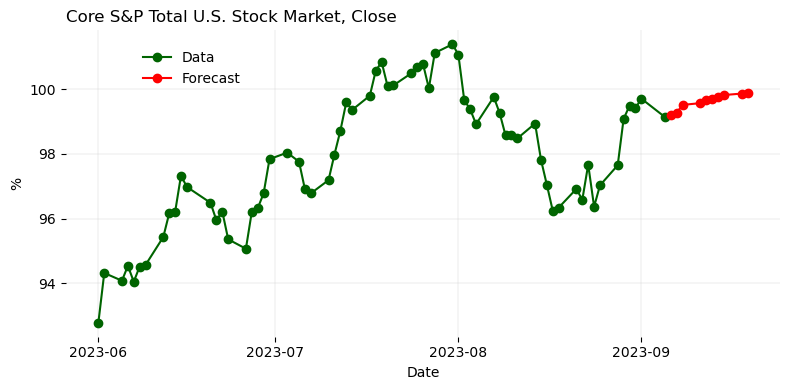

In [16]:
start_plot = pd.to_datetime('2023-06-01')
ITOT_s = ITOT[ITOT.index >= start_plot]

plt.figure(figsize=(8, 4))
plt.plot(ITOT_s.index, ITOT_s, label='Data', color='darkgreen', linestyle='-', marker='o')
plt.plot(ITOT_f.index, ITOT_f['forecast'], label='Forecast', color='red', linestyle='-', marker='o')

plt.xlabel('Date')
plt.ylabel('%')
plt.title('Core S&P Total U.S. Stock Market, Close', loc='left')
plt.legend(loc=(0.1, 0.8), frameon=False)
plt.grid(which='major', color='lightgrey', linewidth=0.3)
plt.box(False)

plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))

plt.tight_layout()
plt.show()

 Plot subset of data and 1-step ahead in-sample forecasts

In [17]:
data = ITOT
f_start = pd.to_datetime('2023-06-01')
T = len(data)
y = pd.DataFrame(data[data.index >= f_start])

s = len(y)
y['y.hat'] = 0.

for j in range(s):
    t = T-s+j
    ydat = data.iloc[:t]
    ro.globalenv['ydat'] = ydat['ITOT']
    ro.r('base::set.seed(seed)')
    ro.r('nnetar_model <- forecast::nnetar(ydat, p=5, P=0, size=4)') 
    ro.r('NN_f <- forecast::forecast(nnetar_model,h=1)') # forecast 1 time step ahead
    ro.r('NN_fm <- as.numeric(NN_f$mean)')
    NN_fm = ro.globalenv['NN_fm']
    y.at[y.index[j], 'y.hat'] = NN_fm

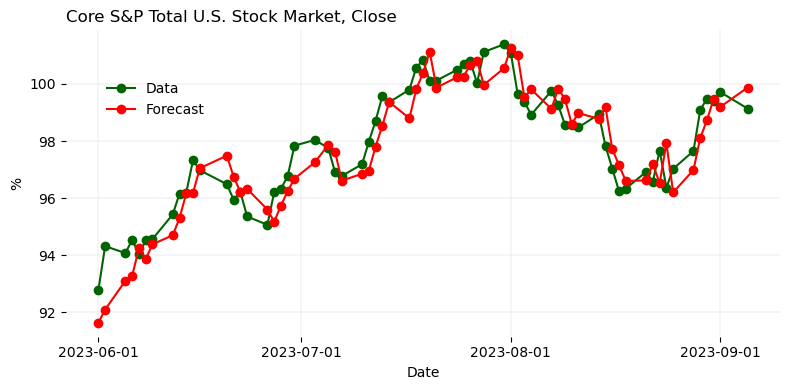

In [18]:
plt.figure(figsize=(8, 4))
# plot data
plt.plot(y.index, y['ITOT'], label='Data', color='darkgreen', linestyle='-', marker='o')
# plot forecast
plt.plot(y.index, y['y.hat'], label='Forecast', color='red', linestyle='-', marker='o')

plt.xlabel('Date')
plt.ylabel('%')
plt.title('Core S&P Total U.S. Stock Market, Close', loc='left')
plt.legend(loc=(0.05, 0.7), frameon=False)
plt.grid(which='major', color='lightgrey', linewidth=0.3)
plt.box(False)

plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1)) # labels every 2 weeks
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))

plt.tight_layout()
plt.show()